# Deep ensambles

In this notebook we investigate the effect of using deep ensambles on the calibration of the model uncertainty prediction.

1. The ensamble of models is obtained by picking the best 5 of 10 trained instances, which diferentiate in the traiing hyperparameters.
2. the models predictions are grouped together via Hugarian algorithms iwth a given IoU threshold
3. The detections belonging to the same group are aggragated according to several aggregation methods: score average, max score, weighted average of the box coordinates....

In [1]:
import os
import sys
import shutil
import pickle as pkl
from tqdm import tqdm
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt



from src.model.dataset import InferenceMaskRCNNDataset, MaskRCNNDataset
from src.model.engine import FitterMaskRCNN
from src.model.model import maskRCNNModel

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. Load the models and the data



In [2]:
iou_threshold = 0.5
bins_extremes=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = list(range(len(bins_extremes) - 1))


model_aug_dir = "../weights/ensamble/aug"
model_no_aug_dir = "../weights/ensamble/no_aug"

train_dataset_path = "../dataset/train"
val_dataset_path = "../dataset/val"
test_dataset_path = "../dataset/test"

output_dir = "ensamble_predictions"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

train_dataset = MaskRCNNDataset(train_dataset_path, datatype="eval")
val_dataset = MaskRCNNDataset(val_dataset_path, datatype="eval")
test_dataset = MaskRCNNDataset(test_dataset_path, datatype="eval")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))

engine = FitterMaskRCNN()

test_predictions = {}
# run inference on the test set
for model_dir in [model_aug_dir, model_no_aug_dir]:
    for model_path in os.listdir(model_dir):
        if not model_path.endswith(".bin"):
            continue
        prediciton_path = os.path.join(output_dir, f"{model_path.split('.')[0]}_test_predictions.pkl")
        if os.path.exists(prediciton_path):
            compressed_pred = pkl.load(open(prediciton_path, "rb"))
        else:
            print(f"Running inference on {model_path} from {model_dir}")
            model = maskRCNNModel()
            model.load_state_dict(torch.load(os.path.join(model_dir, model_path), map_location=torch.device('cpu'))['model_state_dict'])
            model.eval()
            
            # We want to keep all the predictions for our analisys
            predictinos = engine.inference(model, test_loader, 0.0)
            compressed_pred = {}
            for i, pred in enumerate(predictinos):
                if pred is not None:
                    compressed_pred[i] = {
                        "boxes": pred["boxes"].cpu().numpy(),
                        "scores": pred["scores"].cpu().numpy(),
                    }
            # Save the prediciton
            pkl.dump(compressed_pred, open(prediciton_path, "wb"))
        test_predictions[model_path.split('.')[0]] = compressed_pred


/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


# Merge the predicitons

Naive algorithm: each group is a maximally large set of predictinos (of different models) that have an IOU greater than 

In [3]:
def compute_iou(box_1, box_2):
    # compute the intersection over union of two bounding boxes
    x1 = max(box_1[0], box_2[0])
    y1 = max(box_1[1], box_2[1])
    x2 = min(box_1[2], box_2[2])
    y2 = min(box_1[3], box_2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box_1 = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    area_box_2 = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    
    union = area_box_1 + area_box_2 - intersection
    
    if union == 0:
        return 0.0
    return intersection / union

def compute_iou_matrix(bboxes_1, bboxes_2):
    # compute the iou matrix
    iou_matrix = np.zeros((len(bboxes_1), len(bboxes_2)))
    for i, box_1 in enumerate(bboxes_1):
        for j, box_2 in enumerate(bboxes_2):
            iou_matrix[i, j] = compute_iou(box_1, box_2)
    return iou_matrix

def compute_iou_group(group, bboxes):
    iou_matrix = compute_iou_matrix(group,bboxes)
    return np.min(iou_matrix, axis=0)

def instance_matcher(iou_matrix, iou_threshold: float = 0.5):
    # filter out the matches with low iou
    iou_matrix[iou_matrix < iou_threshold] = 0
    # Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(iou_matrix, maximize=True)
    # fileter out the matches (some of them might be an artifact of the Hungarian algorithm)
    row_ind_threshold = []
    col_ind_threshold = []
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            row_ind_threshold.append(i)
            col_ind_threshold.append(j)
    return row_ind_threshold, col_ind_threshold



In [25]:
merged_predictions = {}
for z in range(len(test_predictions)):
    merged_predictions[z] = {}  
    for i in tqdm(range(len(test_dataset))):
        # Get the predictions for the i-th image
        bboxes = []
        scores = []
        for k, (model_name, predictions) in enumerate(test_predictions.items()):
            if i not in predictions:
                continue
            bboxes.append(predictions[i]["boxes"])
            scores.append(predictions[i]["scores"])
            if k == z:
                if i == 0:
                    print(f"Using {k+1} models")
                break
        
        
        if len(bboxes) == 0:
            continue
        
        # Compute the IOU matrix    
        # Group the predictions based on IOU threshold
        merged_bboxes = []
        merged_scores = []
        # sort by confidence score
        bboxes = np.concatenate(bboxes)
        scores = np.concatenate(scores)
        sorted_indices = np.argsort(-scores)  # Sort indices by descending scores
        bboxes = bboxes[sorted_indices]
        scores = scores[sorted_indices]
        # print(f"Image {i}: {len(bboxes)} predictions")
        available = [True for _ in range(len(bboxes))]
        for j in range(len(bboxes)):
            # print(f"Processing box {j}/{len(bboxes)}")
            if not available[j]:
                # print(f"Box {j} already processed, skipping.")
                continue
            # Start a new group with the current box
            # print(f"Starting new group with box {j}")
            group = [j]
            bboxes_group = [bboxes[j]]
            scores_group = [scores[j]]
            available [j] = False
            while available.count(True) > 0:
                ious = compute_iou_group(bboxes_group, bboxes[available])
                k = np.argmax(ious)
                if ious[k] < iou_threshold:
                    # print(f"Group {len(merged_bboxes)}: {len(group)} boxes, IOU {ious[k]}")
                    break
                # Add the new box to the group
                # print(f"Adding box {np.where(available)[0][k]} to group")
                group.append(np.where(available)[0][k])
                bboxes_group.append(bboxes[available][k])
                scores_group.append(scores[available][k])
                available[np.where(available)[0][k]] = False
            merged_bboxes.append(np.mean(bboxes_group, axis=0))
            merged_scores.append(np.sum(scores_group)/ len(test_predictions))
        merged_predictions[z][i] = {
            "boxes": np.array(merged_bboxes),
            "scores": np.array(merged_scores),
        }

 60%|██████    | 9/15 [00:00<00:00, 32.31it/s]

Using 1 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 2 models


  7%|▋         | 1/15 [00:00<00:02,  4.80it/s]

Using 3 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 4 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 5 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 6 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 7 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 8 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 9 models


  0%|          | 0/15 [00:00<?, ?it/s]

Using 10 models


100%|██████████| 15/15 [03:08<00:00, 12.54s/it]


# Process detections

Compute how many detections are a true positive and how many are not

In [28]:
iou_thresholds = [iou_threshold]
def process_predictions(predictions, dataset):
    detections = {i: pd.DataFrame(columns=["image_id", "decetion_id", "confidence_score", "accuracy"]) for i in iou_thresholds}
    for image_id, image_predictions in tqdm(enumerate(predictions)):
        _, labels = dataset[image_id]
        print(image_predictions)
        iou_matrix = compute_iou_matrix(image_predictions["boxes"], labels["boxes"])
        for iou in iou_thresholds:
            row_ind, col_ind = instance_matcher(iou_matrix, iou_threshold=iou)
            for detection_id in range(len(image_predictions["boxes"])):
                confidence_score = image_predictions["scores"][detection_id].item()
                accuracy = int(detection_id in col_ind)
                detections[iou].loc[len(detections[iou])] = [image_id, detection_id, confidence_score, accuracy]

    # plot number fo positive and negative detections
    df = pd.DataFrame(columns=["iou_threshold", "true positive", "false positive"])
    for iou in iou_thresholds:
        positive = detections[iou][detections[iou]["accuracy"] == 1].shape[0]
        negative = detections[iou][detections[iou]["accuracy"] == 0].shape[0]
        df.loc[len(df)] = [iou, positive, negative]
    display(df)
    return detections

processed_merged_predictions = {}
print(merged_predictions.keys())
print(merged_predictions[0].keys())
print(merged_predictions[0][0])
for i in range(len(merged_predictions)):
    processed_merged_predictions[i] = process_predictions(merged_predictions[i], test_dataset)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
{'boxes': array([[1289.6965  , 1166.1692  , 1339.5566  , 1218.6578  ],
       [1092.5719  , 1329.6476  , 1123.5431  , 1363.8708  ],
       [ 174.67862 ,  839.98505 ,  229.79518 ,  891.8104  ],
       [1287.8951  , 1382.536   , 1321.2251  , 1420.6104  ],
       [1558.8627  ,  618.6106  , 1603.6294  ,  668.95435 ],
       [ 819.5086  ,  955.60803 ,  858.9237  ,  989.3642  ],
       [1104.5924  , 1154.9603  , 1138.1975  , 1189.337   ],
       [ 982.9106  ,  909.4752  , 1033.6165  ,  958.0414  ],
       [1370.9479  ,  735.55804 , 1428.2712  ,  792.79803 ],
       [1488.495   ,  217.70596 , 1535.3156  ,  271.2595  ],
       [1436.1982  , 1241.5338  , 1467.249   , 1277.1614  ],
       [ 609.5307  ,  680.0066  ,  649.0916  ,  718.9882  ],
       [ 564.7472  , 1106.9686  ,  643.2349  , 1183.242   ],
       [ 190.99524 ,  440.3697  ,  243.93726 ,  489.27945 ],
       [ 630.8802  , 1013.72925 

0it [00:00, ?it/s]

0


TypeError: 'int' object is not subscriptable

# Calibration Plot

Show the calibration plot of the ensamble model

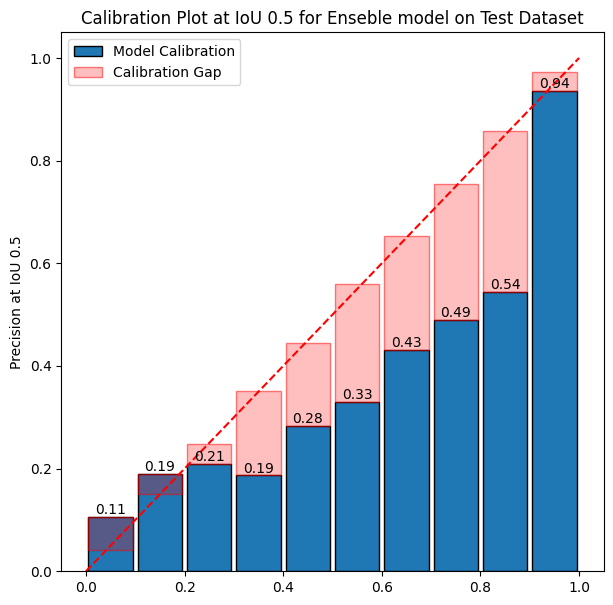

Calibration Error at IoU 0.5: 0.108


In [ ]:
def bin_predictions(detections: pd.DataFrame):
    detections = detections.copy()
    detections["bin"] = pd.cut(detections["confidence_score"], bins=bins_extremes, labels=labels)
    bins = detections.groupby("bin", observed=False)["accuracy"].mean().reset_index()
    bins["count"] = detections.groupby("bin", observed=False)["accuracy"].count().values
    bins["confidence"] = detections.groupby("bin", observed=False)["confidence_score"].mean().values
    bins["interval"] = bins_extremes[1:]
    return bins

def plot_calibration(detections: dict, dataset: str, iou: float):
    bins = bin_predictions(detections.copy())
    # sns.barplot(data=bins, x="interval", y="accuracy")
    plt.figure(figsize=(7, 7))
    
    bars = plt.bar(x=bins["interval"]- 0.05, height=bins["accuracy"], width=0.09, edgecolor='black', label='Model Calibration')
    plt.bar(x=bins["interval"]- 0.05, height=bins["confidence"] - bins["accuracy"], bottom=bins["accuracy"], color=('red', 0.25), width=0.09, label='Calibration Gap', edgecolor=('red', 0.5))
    plt.bar_label(bars, fmt='%.2f')
    # plt.bar_label(bins["accuracy"].to_list())
    plt.ylabel(f"Precision at IoU {iou}")
    plt.plot(bins_extremes, bins_extremes, color='red', linestyle='--')
    plt.legend()
    plt.title(f"Calibration Plot at IoU {iou} for {dataset} Dataset")
    plt.show()
    ce = compute_calibration_error(bins)
    print(f"Calibration Error at IoU {iou}: {ce:.3f}")
    return ce

def compute_calibration_error(bins):
    # compute the calibration score
    ce = 0.0
    for index, row in bins.iterrows():
        if row["count"] == 0:
            continue
        ce += abs(row["accuracy"] - row["confidence"]) * row["count"]
    ce /= bins["count"].sum()
    return ce

 
ens_ce = plot_calibration(processed_merged_predictions[iou_threshold], "Enseble model on Test", iou_threshold)

# Compare

For comparison we wnat to see how the models perform on their own, we compute the calibration error for each model independently and compare it to the CE of the ensamble

In [ ]:
individual_ce = []
for model, predictions in test_predictions.items():
    print(model)
    pred = process_predictions(predictions, test_dataset)
    individual_ce.append(plot_calibration(pred[iou_threshold], "Test", iou_threshold))
print(individual_ce)
print(sum(individual_ce)/len(individual_ce))

best-checkpoint-16


0it [00:00, ?it/s]


TypeError: 'int' object is not subscriptable

In [ ]:
plt.boxplot(individual_ce, label="Individual CE")
plt.plot(2, ens_ce, "bo", label="Ensemble CE")
plt.legend()
plt.xlim(0.5,2.5)
plt.ylim(0,0.25)
plt.title("Calibration Error Comparison")

# Model performances

Next we compare the mnode performance of the ensable comaped to all the other mnodels taken singularly

In [ ]:
import copy
def ap(pred_boxes, target_boxes, iou_thresholds: list):
    iou_matrix = compute_iou_matrix(pred_boxes, target_boxes)
    precision = 0.
    recall = 0.
    for iou_threshold in iou_thresholds:
        row_ind, col_ind = instance_matcher(copy.deepcopy(iou_matrix), iou_threshold)
        # filter out the matches
        tp = len(row_ind)
        fp = len(pred_boxes) - tp
        fn = len(target_boxes) - tp
        # compute the precision and recall
        precision += tp / (tp + fp) if (tp + fp) > 0 else 0
        recall += tp / (tp + fn) if (tp + fn) > 0 else 0
    precision /= len(iou_thresholds)
    recall /= len(iou_thresholds)
    return precision, recall

def map(preds, targets, iou_thresholds: list, confidece_threshold: float = 0.5):
    # compute the mean average precision
    precision = 0.
    recall = 0.
    preds = FitterMaskRCNN.filter_predicitons(preds, confidece_threshold)
    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        target_boxes = target['boxes'].cpu().numpy()
        p, r = ap(pred_boxes, target_boxes, iou_thresholds)
        precision += p
        recall += r
    precision /= len(preds)
    recall /= len(preds)
    return precision, recall

In [ ]:
target = []
for _, t in test_dataset:
    target.append(t)

for p in merged_predictions:
    p["labels"] = torch.ones(len(p["scores"]))
    p["masks"] = torch.ones(len(p["scores"]))
    p["scores"] = torch.tensor(p["scores"])
    p["boxes"] = torch.tensor(p["boxes"])

map_ensemble= map(
    preds=merged_predictions,
    targets=target,
    iou_thresholds=np.linspace(0.5, 0.95, 10),
    confidece_threshold = 0.5,
)


print(f"MAP ensemble: {map_ensemble}")




/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_48073/3529155064.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p["scores"] = torch.tensor(p["scores"])
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_48073/3529155064.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p["boxes"] = torch.tensor(p["boxes"])


MAP ensemble: (0.4872975092413862, 0.456190609452631)
